In [1]:
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from torch.nn import Module, Linear, Sequential, Softplus, ReLU
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [2]:
# Load the dataset. 
# molecule_features: First col is a string containing name of molecule. Rest are floats containing its features
# eutectic_compilation: First 2 cols are strings containing molecule names, third col is eutectic proportion, fourth is eutectic temperature

molecule_features = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\single_components.csv").drop(["xlogp"], axis=1)
eutectic_compilation = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\eutectic_compilation.csv")

molecule_features[molecule_features.columns[1:]] = molecule_features[molecule_features.columns[1:]].astype(float)
eutectic_compilation[eutectic_compilation.columns[3]] = eutectic_compilation[eutectic_compilation.columns[3]].astype(float)

In [3]:
# Some indices in eutectic_compilation do not exist in single_components. They will need to be removed.
# Some of the eutectic proportions are inconvertible to floats from strings. They will also need to be removed.
# missing_molecules will store all molecules that are missing features from eutectic_compilation
drops = np.array([]).astype(int)
missing_molecules = np.array([]).astype(str)
for i in range(len(eutectic_compilation)):
    ec = eutectic_compilation.iloc[i]
    m1 = ec[0]
    m2 = ec[1]
    xe = ec[2]
    
    m1f = molecule_features.loc[molecule_features.mol == ec[0]]
    m2f = molecule_features.loc[molecule_features.mol == ec[1]]
    
    try:
        xe = float(xe)
    except ValueError:
        drops = np.append(drops, i)
    
    if(len(m1f) == 0 or len(m2f) == 0):
        drops = np.append(drops, i)
        
        if(len(m1f) == 0):
            missing_molecules = np.append(missing_molecules, m1)
        elif(len(m2f) == 0):
            missing_molecules = np.append(missing_molecules, m2)

eutectic_compilation = eutectic_compilation.drop(eutectic_compilation.index[drops])
# np.savetxt("missing_molecules.csv", missing_molecules, delimiter=",", fmt="%s")

In [4]:
# Split the eutectic compilation dataframe by a ratio into training and testing sets
split = 0.95
train_ec = eutectic_compilation.sample(frac=split)
test_ec = eutectic_compilation.drop(train_ec.index)

split = 0.10
val_ec = train_ec.sample(frac=split)
train_ec = train_ec.drop(val_ec.index)

In [5]:
molecule_features

,mol,molecular_weight,complexity,rotatable_bond_count,heavy_atom_count,topological_area
0,BaO,153.3300,2.0,0.0,2.0,17.1
1,CrCl3,158.3500,0.0,0.0,4.0,0.0
2,PBr5,430.4900,37.1,0.0,6.0,0.0
3,WCl5,361.1000,37.1,0.0,6.0,0.0
4,HgI2,454.4000,2.8,0.0,3.0,0.0
...,...,...,...,...,...,...
672,PBr3,270.6900,8.0,0.0,4.0,0.0
673,PbSiO3,283.0000,18.8,0.0,5.0,63.2
674,LiI,133.9000,2.0,0.0,2.0,0.0
675,EuF3,208.9590,8.0,0.0,4.0,0.0


In [6]:
train_ec

,molA,molB,xe,Te
1174,KBr,LiBr,60,318.0
673,LiClO4,NaClO4,72.5,208.0
591,LiNO3,NaNO3,54,193.0
2137,LiCl,LiPO3,57,540.0
927,Na2Cr2O7,NaNO3,45.4,262.0
...,...,...,...,...
1304,BeCl2,CaCl2,85,355.0
4355,Cr2O3,FeO,67.5,1900.0
1822,Cu2S,Na2S,39.8,480.0
3004,K2NbF7,LiF,83.5,682.0


In [7]:
val_ec

,molA,molB,xe,Te
1549,CaCl2,TlCl,7.5,419.0
72,AlBr3,SnBr4,26,20.0
141,AlCl3,GaCl3,6,74.0
2029,KCl,Na2SO4,60.9,517.1
1354,AgCl,InCl3,77,369.0
...,...,...,...,...
3478,Rb2O,SiO2,15.8,770.0
1473,InCl,TlCl,8,400.0
2319,CsBO2,LiCl,5,574.0
2071,BeF2,MgF2,95,528.0


In [8]:
test_ec

,molA,molB,xe,Te
1,BF3,SO2,95.2,-128.6
58,POCl3,WCl6,100,1.0
62,AsBr3,SnBr4,45,3.5
113,CuCl,GaCl3,5.2,60.0
138,AlBr3,AlCl3,65,73.0
...,...,...,...,...
4382,La2O3,Sc2O3,76,2000.0
4405,MgO,Sc2O3,44,2080.0
4429,CaO,ZrO2,68,2150.0
4439,SrO,ZrO2,80,2215.0


In [9]:
print(molecule_features.columns)
print(eutectic_compilation.columns)

Index(['mol', 'molecular_weight', 'complexity', 'rotatable_bond_count',
       'heavy_atom_count', 'topological_area'],
      dtype='object')
Index(['molA', 'molB', 'xe', 'Te'], dtype='object')


In [10]:
print(molecule_features.dtypes)
print(eutectic_compilation.dtypes)

mol                      object
molecular_weight        float64
complexity              float64
rotatable_bond_count    float64
heavy_atom_count        float64
topological_area        float64
dtype: object
molA     object
molB     object
xe       object
Te      float64
dtype: object


In [11]:
molecule_features.iloc[0]

mol                        BaO
molecular_weight        153.33
complexity                 2.0
rotatable_bond_count       0.0
heavy_atom_count           2.0
topological_area          17.1
Name: 0, dtype: object

In [12]:
print("Train Size: ", len(train_ec))
print("Validation Size: ", len(val_ec))
print("Test Size: ", len(test_ec))

Train Size:  3403
Validation Size:  378
Test Size:  199


In [39]:
# SNN class with model
class SiameseNeuralNetwork(Module):
    def __init__(self, start_features):
        super(SiameseNeuralNetwork, self).__init__()
        
        self.model = Sequential(
            Linear(in_features=start_features, out_features=4, bias=False),
            Linear(in_features=4, out_features=3, bias=False),
        )
        
        self.fc1 = Linear(in_features=6, out_features=6, bias=False) # distance metric calculation stage
        self.fc2 = Linear(in_features=6, out_features=1, bias=False) # final stage where prediction is made

    def forward(self, x1, x2, marker="xe"):
        if marker == "xe":
            return self.xe(x1, x2)
        elif marker == "Te":
            return self.te(x1, x2)
        
    def xe(self, x1, x2):
        y1 = self.model(x1)               # (batchsize, 3)
        y2 = self.model(x2)               # (batchsize, 3)
        y = torch.cat([y1, y2], 1)        # (batchsize, 6)
        
        with torch.no_grad():
            self.fc1.weight[:, 3:6] = -1 * self.fc1.weight[:, 0:3]
        
        d = self.fc1(y)                   # distance metric (batchsize, 6)
        p = torch.sigmoid(self.fc2(d))    # output for xe   (batchsize, 1)
        return p
    
    def te(self, x1, x2):
        y1 = self.model(x1)
        y2 = self.model(x2)   
        d = torch.abs(y1 - y2)           # difference for Te
        p = self.fc(d)                   # output for Te
        return p

In [40]:
class MakeDataset(Dataset):
    def __init__(self, ec_df, mf_df, num_features):
        self.ecdf = ec_df
        self.mfdf = mf_df
        self.nf = num_features

    def __len__(self):
        return len(self.ecdf)
  
    def __getitem__(self, idx):
        ec = self.ecdf.iloc[idx]
        
        m1f = torch.tensor(np.array(self.mfdf.loc[self.mfdf.mol == ec[0]])[0][1:self.nf+1].astype(float))
        m2f = torch.tensor(np.array(self.mfdf.loc[self.mfdf.mol == ec[1]])[0][1:self.nf+1].astype(float))
        xe = torch.tensor(float(ec[2]))
        Te = torch.tensor(ec[3])
        
        return m1f, m2f, xe, Te

In [41]:
# define parameters for training
starting_features = 5
batchsize = 25
train_dset = MakeDataset(train_ec, molecule_features, starting_features)
val_dset = MakeDataset(val_ec, molecule_features, starting_features)
test_dset = MakeDataset(test_ec, molecule_features, starting_features)

Adjusting learning rate of group 0 to 1.0000e-06.
Adjusting learning rate of group 0 to 1.0030e-06.
Epoch 1 | Train Loss: 25.964 | Train Baseline: 35.202 | Val Loss: 3.315 | Val Baseline: 4.213
Adjusting learning rate of group 0 to 1.0060e-06.
Epoch 2 | Train Loss: 25.748 | Train Baseline: 35.324 | Val Loss: 3.244 | Val Baseline: 3.941
Adjusting learning rate of group 0 to 1.0090e-06.
Epoch 3 | Train Loss: 25.722 | Train Baseline: 35.316 | Val Loss: 2.92 | Val Baseline: 4.058
Adjusting learning rate of group 0 to 1.0120e-06.
Epoch 4 | Train Loss: 25.662 | Train Baseline: 35.447 | Val Loss: 2.905 | Val Baseline: 4.152
Adjusting learning rate of group 0 to 1.0150e-06.
Epoch 5 | Train Loss: 25.486 | Train Baseline: 35.356 | Val Loss: 2.875 | Val Baseline: 4.033
Adjusting learning rate of group 0 to 1.0180e-06.
Epoch 6 | Train Loss: 25.495 | Train Baseline: 35.232 | Val Loss: 3.138 | Val Baseline: 4.218
Adjusting learning rate of group 0 to 1.0210e-06.
Epoch 7 | Train Loss: 25.372 | Train 

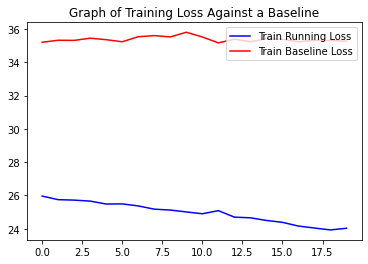

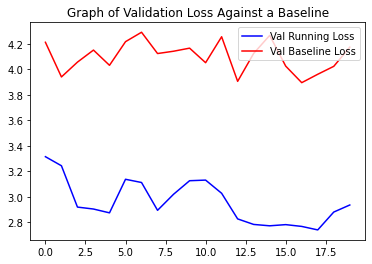

Test Loss: 1.461 | Test Baseline: 2.089



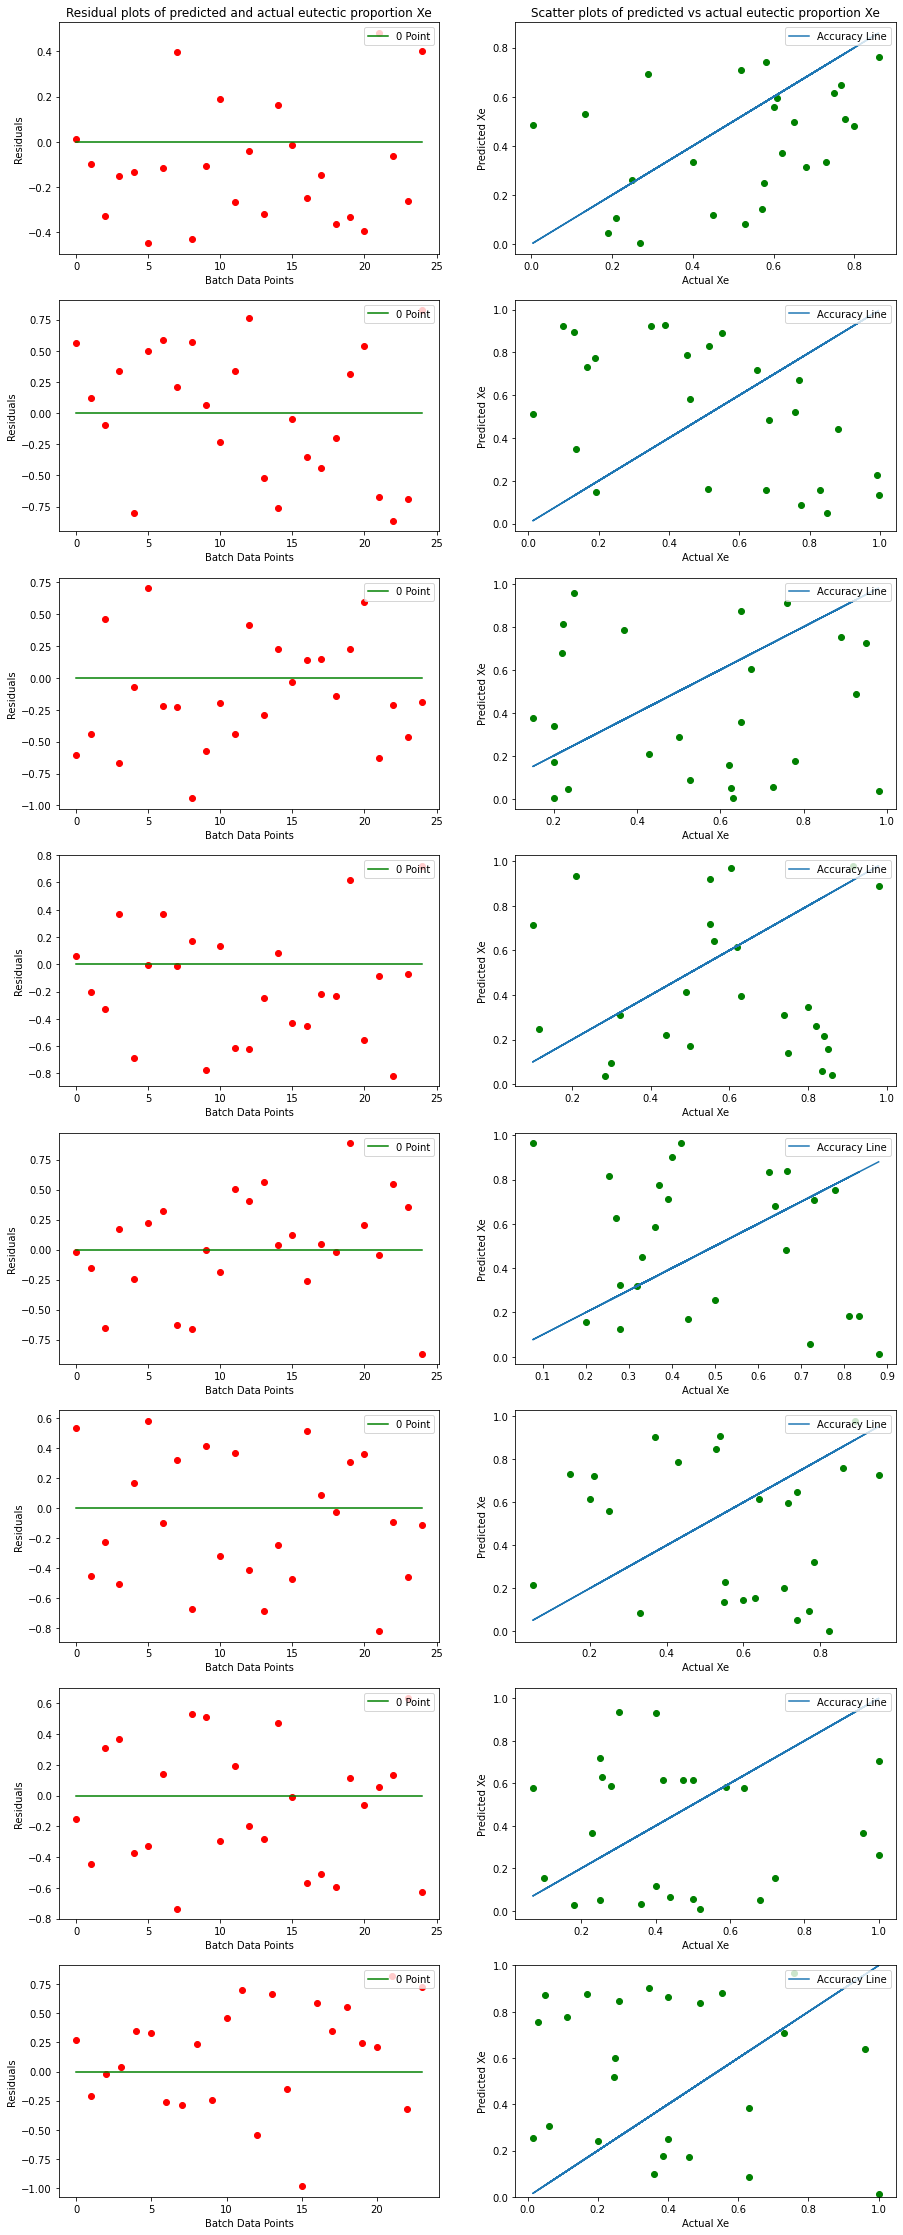

f(A,B): 
 tensor([0.5183, 0.1755, 0.7083, 0.2423, 0.5986, 0.8832, 0.1006, 0.1737, 0.2529,
        0.3854, 0.8622, 0.8748, 0.0874, 0.7770, 0.2502, 0.0136, 0.8474, 0.8379,
        0.9026, 0.3046, 0.9669, 0.8713, 0.6373, 0.7537])


f(B,A): 
 tensor([0.4817, 0.8245, 0.2917, 0.7577, 0.4014, 0.1168, 0.8994, 0.8263, 0.7471,
        0.6146, 0.1378, 0.1252, 0.9126, 0.2230, 0.7498, 0.9864, 0.1526, 0.1621,
        0.0974, 0.6954, 0.0331, 0.1287, 0.3627, 0.2463])


f(A,B) + f(B,A): 
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


Original Values: 
 tensor([0.2450, 0.3870, 0.7300, 0.2000, 0.2500, 0.5550, 0.3600, 0.4600, 0.0146,
        0.6300, 0.4000, 0.1700, 0.6320, 0.1120, 0.4000, 1.0000, 0.2600, 0.4900,
        0.3470, 0.0600, 0.7600, 0.0500, 0.9600, 0.0300])


Predicted Values: 
 tensor([0.5183, 0.1755, 0.7083, 0.2423, 0.5986

In [43]:
# For Xe
train_ec_dl = DataLoader(train_dset, shuffle=True, batch_size=batchsize)
val_ec_dl = DataLoader(val_dset, shuffle=True, batch_size=batchsize)
test_ec_dl = DataLoader(test_dset, shuffle=True, batch_size=batchsize)

# Set the model and training parameters
model = SiameseNeuralNetwork(starting_features)
num_epochs = 20
learn_rate = 1e-6

# Set optimizer and loss function. Using MSE for regression. Have lr_scheduler for adaptive learning 
opt = torch.optim.SGD(model.parameters(), lr=learn_rate)
sch = torch.optim.lr_scheduler.CyclicLR(opt, base_lr=learn_rate, max_lr=7e-6, mode='exp_range', verbose=True)
criterion = torch.nn.MSELoss()

# Set the baselines for training, validation, and testing
# MSE is basically variance, so the baseline is the variance of the dataset
train_base_xe = torch.std(torch.tensor(np.array(train_ec["xe"]).astype(float) / 100.0))**2
val_base_xe = torch.std(torch.tensor(np.array(val_ec["xe"]).astype(float) / 100.0))**2
test_base_xe = torch.std(torch.tensor(np.array(test_ec["xe"]).astype(float) / 100.0))**2

###################################### Training ######################################
trloss = np.array([])
trbase = np.array([])
vloss = np.array([])
vbase = np.array([])
for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0
    train_base_loss = 0.0
    val_running_loss = 0.0
    val_base_loss = 0.0

    # training step: iterate through the batch and obtain the 4 data
    for x, (m1, m2, xe, Te) in enumerate(train_ec_dl):   
        opt.zero_grad()
        xe = xe/100.0
        
        # pass 2 sets of inputs into the snn and get p, the output
        output = model(m1.float(), m2.float(), "xe")
        
        loss = criterion(output[:, 0], xe)
        
        base = torch.full((len(xe),), train_base_xe)     # create same value array
        base_loss = criterion(base, xe)                  # obtain baseline loss

        loss.backward()
        opt.step()

        train_running_loss += loss.item()
        train_base_loss += base_loss.item()
    
    sch.step()
    model.eval()
    for v, (m1, m2, xe, Te) in enumerate(val_ec_dl):
        xe = xe/100.0
        
        output = model(m1.float(), m2.float(), "xe")
        val_running_loss += criterion(output[:, 0], xe).item()
        
        base = torch.full((len(xe), ), val_base_xe)
        val_base_loss += criterion(base, xe).item()
        

    print('Epoch {} | Train Loss: {} | Train Baseline: {} | Val Loss: {} | Val Baseline: {}'.format(
        epoch+1, 
        np.round(train_running_loss, 3), 
        np.round(train_base_loss, 3), 
        np.round(val_running_loss, 3), 
        np.round(val_base_loss, 3)))
    
    trloss = np.append(trloss, train_running_loss)
    trbase = np.append(trbase, train_base_loss)
    vloss = np.append(vloss, val_running_loss)
    vbase = np.append(vbase, val_base_loss)

x = np.arange(num_epochs)
plt.figure(1)
plt.plot(x, trloss, label="Train Running Loss", c="blue")
plt.plot(x, trbase, label="Train Baseline Loss", c="red")
plt.title("Graph of Training Loss Against a Baseline")
plt.legend(loc="upper right")
plt.show()

plt.figure(2)
plt.plot(x, vloss, label="Val Running Loss", c="blue")
plt.plot(x, vbase, label="Val Baseline Loss", c="red")
plt.title("Graph of Validation Loss Against a Baseline")
plt.legend(loc="upper right")
plt.show()

###################################### Testing and Plotting ###################################### 
test_loss = 0.0
test_baseline = 0.0
model.eval()

fig, axes = plt.subplots(8, 2)
fig.set_figheight(40)
fig.set_figwidth(15)
row = 0

with torch.no_grad():
    for y, (m1, m2, xe, Te) in enumerate(test_ec_dl):
        xe = xe/100.0

        outputs = model(m1.float(), m2.float(), "xe")
        invouts = model(m2.float(), m1.float(), "xe")

        test_loss += criterion(outputs[:, 0], xe).item()

        base = torch.full((len(xe),), test_base_xe)
        test_baseline += criterion(base, xe).item()

        x = np.arange(len(xe))

        axes[row, 0].scatter(x, outputs.detach().numpy() - xe[np.newaxis].numpy().T, c="red")
        axes[row, 0].plot(x, np.zeros((len(xe.numpy()),)), c="green", label="0 Point")
        axes[row, 0].set(xlabel="Batch Data Points", ylabel="Residuals")
        axes[row, 0].legend(loc="upper right")

        axes[row, 1].scatter(xe.numpy(), outputs.detach().numpy(), c="green")
        axes[row, 1].plot(xe.numpy(), xe.numpy(), label="Accuracy Line")
        axes[row, 1].set(xlabel="Actual Xe", ylabel="Predicted Xe")
        axes[row, 1].legend(loc="upper right")
        
        plt.ylim([0, 1])

        row += 1
        if row == 8:
            break

    print('Test Loss: {} | Test Baseline: {}\n'.format(
        np.round(test_loss, 3), 
        np.round(test_baseline, 3)))

    axes[0, 0].set_title("Residual plots of predicted and actual eutectic proportion Xe")
    axes[0, 1].set_title("Scatter plots of predicted vs actual eutectic proportion Xe")
    plt.show()

    # fig.savefig('D:\\Research\\UConn_ML\\Images\\snn_results_plots.png')
    
# should all be 1 or close to 1 to show that f(A,B) = 1 - f(B,A)
print("f(A,B): \n", outputs.flatten())
print("\n")
print("f(B,A): \n", invouts.flatten())
print("\n")
l = min(len(outputs), len(invouts))
print("f(A,B) + f(B,A): \n", outputs[0:l].flatten() + invouts[0:l].flatten())
print("\n")
print("Original Values: \n", xe)
print("\n")
print("Predicted Values: \n", outputs.flatten())